In [1]:
from pathlib import Path
from Helper import *
import matplotlib.pyplot as plt
from Model import FlowNet, MultiScaleEPE
import time

import IO
from torchvision import transforms
from torch.utils.data import DataLoader

from Model import FlyingChairsDataset


In [2]:
# Cell: Training setup
import torch
import torch.nn as nn
import torch.optim as optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

root = r"E:\datasets\FlyingChairs_release"
# batch_size = 20
batch_size = 8

# Create datasets
train_dataset = FlyingChairsDataset(root=root, split="train", transform=transform)
val_dataset = FlyingChairsDataset(root=root, split="val", transform=transform)

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Using device: cuda
Train samples: 22232
Val samples: 640


In [3]:
# Cell: Iteration-based Training Loop
# Initialize model
model = FlowNet().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = MultiScaleEPE(weights=(1.0, 0.5, 0.25, 0.125))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training configuration
max_iterations = 500_000
val_interval = 100
save_interval = 1000
log_interval = 16


# Learning rate scheduler
def adjust_learning_rate(optimizer, iteration):
    if iteration >= 200000:
        num_halvings = (iteration - 200000) // 100000 + 1
        lr = 1e-4 / (2 ** num_halvings)
    else:
        lr = 1e-4

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


# Setup checkpoint directory
checkpoint_dir = Path('./checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

# Load checkpoint if exists
checkpoint = load_checkpoint_generic(checkpoint_dir, device)

# Initialize tracking variables (all as lists for full history)
train_losses = []
val_losses = []
val_epes = []
iterations_log = []
val_epes_multiscale = []
start_iteration = 1

if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_iteration = checkpoint.get('iteration', 0) + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_epes = checkpoint.get('val_epes', [])
    iterations_log = checkpoint.get('iterations_log', [])
    val_epes_multiscale = checkpoint.get('val_epes_multiscale', [])
    print(f"Resuming training from iteration {start_iteration}")
    print(f"Loaded history: {len(val_losses)} validation points")
else:
    print("No checkpoint found, starting fresh training.")

best_val_loss = checkpoint.get('best_val_loss', float('inf')) if checkpoint else float('inf')
running_loss = 0.0

# Time tracking
start_time = time.time()

model.train()
print(f"\nStarting training from iteration {start_iteration} to {max_iterations:,}...")

iteration = start_iteration

# Main training loop
while iteration <= max_iterations:
    for img_pair, flow_gt in train_loader:
        if iteration > max_iterations:
            break

        # Move to device
        img_pair = img_pair.to(device, non_blocking=True)
        flow_gt = flow_gt.to(device, non_blocking=True)

        # Forward pass
        optimizer.zero_grad()
        flow_preds = model(img_pair)

        # Compute loss
        loss, epe1, epe2, epe3, epe4 = criterion(flow_preds, flow_gt)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Adjust learning rate
        current_lr = adjust_learning_rate(optimizer, iteration)

        # Log progress
        if iteration % log_interval == 0:
            elapsed = time.time() - start_time
            avg_loss = running_loss / log_interval
            train_losses.append(avg_loss)
            print(f"Iter {iteration:6d}/{max_iterations:6d} | Loss: {avg_loss:.4f} | Time: {elapsed:.2f}s")
            running_loss = 0.0
            start_time = time.time()

        # Validation
        if iteration % val_interval == 0:
            model.eval()
            val_loss = 0.0
            val_epe1_sum = 0.0
            val_epe2_sum = 0.0
            val_epe3_sum = 0.0
            val_epe4_sum = 0.0

            with torch.no_grad():
                for img_pair_v, flow_gt_v in val_loader:
                    img_pair_v = img_pair_v.to(device)
                    flow_gt_v = flow_gt_v.to(device)

                    flow_preds_v = model(img_pair_v)

                    loss_v, epe1_v, epe2_v, epe3_v, epe4_v = criterion(flow_preds_v, flow_gt_v)

                    val_loss += loss_v.item()
                    val_epe1_sum += epe1_v.item()
                    val_epe2_sum += epe2_v.item()
                    val_epe3_sum += epe3_v.item()
                    val_epe4_sum += epe4_v.item()

            # Average metrics
            val_loss /= len(val_loader)
            val_epe1 = val_epe1_sum / len(val_loader)
            val_epe2 = val_epe2_sum / len(val_loader)
            val_epe3 = val_epe3_sum / len(val_loader)
            val_epe4 = val_epe4_sum / len(val_loader)

            val_losses.append(val_loss)
            val_epes.append(val_epe1)
            iterations_log.append(iteration)
            val_epes_multiscale.append({
                'epe1': val_epe1,
                'epe2': val_epe2,
                'epe3': val_epe3,
                'epe4': val_epe4
            })

            print(f">>> Validation at iter {iteration:6d} | Val Loss: {val_loss:.4f} | "
                  f"*EPE1: {val_epe1:.4f} |  EPE2: {val_epe2:.4f} | "
                  f" EPE3: {val_epe3:.4f} |  EPE4: {val_epe4:.4f} |  LR: {current_lr:.6f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'iteration': iteration,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_epe': val_epe1,
                    'lr': current_lr,
                    'val_epes_multiscale': {
                        'epe1': val_epe1,
                        'epe2': val_epe2,
                        'epe3': val_epe3,
                        'epe4': val_epe4
                    }
                }, checkpoint_dir / 'best_flownet_model.pth')
                print(f"✓ Saved best model (Loss: {val_loss:.4f}, EPE1: {val_epe1:.4f})")

            model.train()
            start_time = time.time()

        if iteration % save_interval == 0:
            save_checkpoint_generic(
                checkpoint_dir,
                iteration,
                {
                    'iteration': iteration,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr': current_lr,
                    'best_val_loss': best_val_loss,
                    'val_losses': val_losses,
                    'val_epes': val_epes,
                    'iterations_log': iterations_log,
                    'train_losses': train_losses,
                    'val_epes_multiscale': val_epes_multiscale
                },
                max_checkpoints=5
            )

        iteration += 1

print("\n🎉 Training completed!")
print(f"📊 Final statistics:")
print(f"  - Best validation loss: {best_val_loss:.6f}")
print(f"  - Total validation points: {len(val_losses)}")
print(f"  - Total training loss logs: {len(train_losses)}")

Model parameters: 6,907,348
✅ Loaded checkpoint: checkpoints\checkpoint_iteration_467000.pth (iteration 467000)
Resuming training from iteration 467001
Loaded history: 4670 validation points

Starting training from iteration 467001 to 500,000...
Iter 467008/500000 | Loss: 0.8765 | Time: 3.83s
Iter 467024/500000 | Loss: 1.8012 | Time: 6.11s
Iter 467040/500000 | Loss: 1.7972 | Time: 6.08s
Iter 467056/500000 | Loss: 1.8043 | Time: 6.32s
Iter 467072/500000 | Loss: 1.8724 | Time: 6.14s
Iter 467088/500000 | Loss: 2.0423 | Time: 6.40s
>>> Validation at iter 467100 | Val Loss: 3.1117 | *EPE1: 2.3505 |  EPE2: 1.1524 |  EPE3: 0.5863 |  EPE4: 0.3074 |  LR: 0.000013
Iter 467104/500000 | Loss: 1.9263 | Time: 1.48s
Iter 467120/500000 | Loss: 1.7826 | Time: 6.22s
Iter 467136/500000 | Loss: 2.0770 | Time: 6.06s
Iter 467152/500000 | Loss: 1.9540 | Time: 6.37s
Iter 467168/500000 | Loss: 1.9045 | Time: 6.42s
Iter 467184/500000 | Loss: 1.8772 | Time: 6.44s
Iter 467200/500000 | Loss: 2.0369 | Time: 6.39s
>

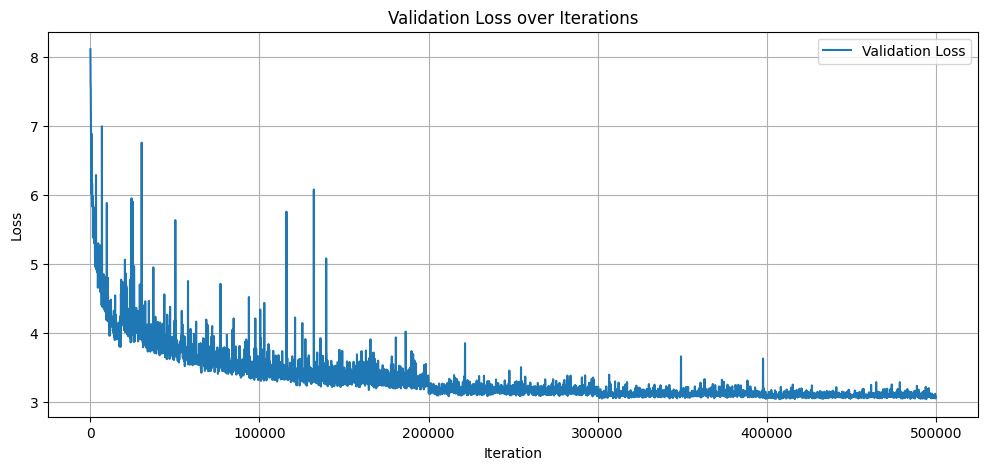

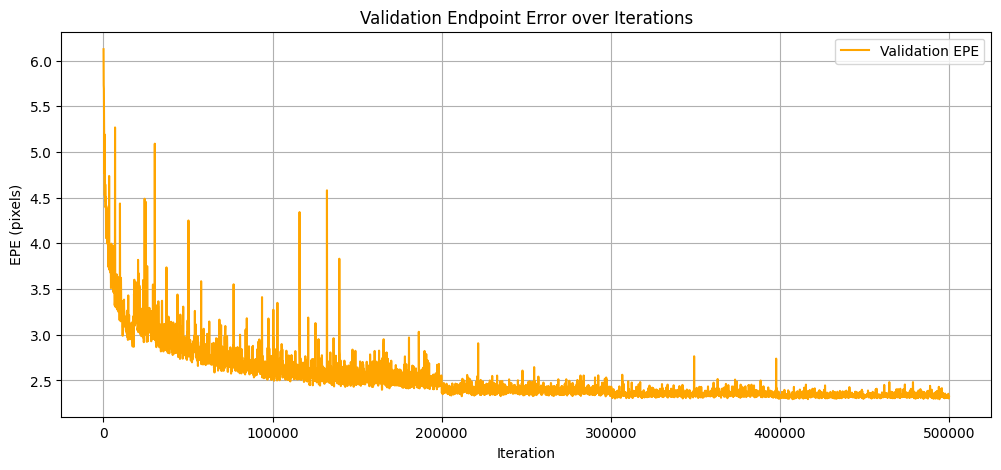

In [4]:
# Plot training curves
def plot_training_curves(iterations_log, val_losses):
    """Plot validation losses over iterations"""
    plt.figure(figsize=(12, 5))
    plt.plot(iterations_log, val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot after training
plot_training_curves(iterations_log, val_losses)

# Plot EPE over iterations
plt.figure(figsize=(12, 5))
plt.plot(iterations_log, val_epes, label='Validation EPE', color='orange')
plt.xlabel('Iteration')
plt.ylabel('EPE (pixels)')
plt.title('Validation Endpoint Error over Iterations')
plt.legend()
plt.grid(True)
plt.show()

✅ Loaded checkpoint: ./checkpoints\checkpoint_iteration_500000.pth (iteration 500000)


C:\Users\simon\PycharmProjects\Napredna-Obdelava-Slik\NOS-N1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


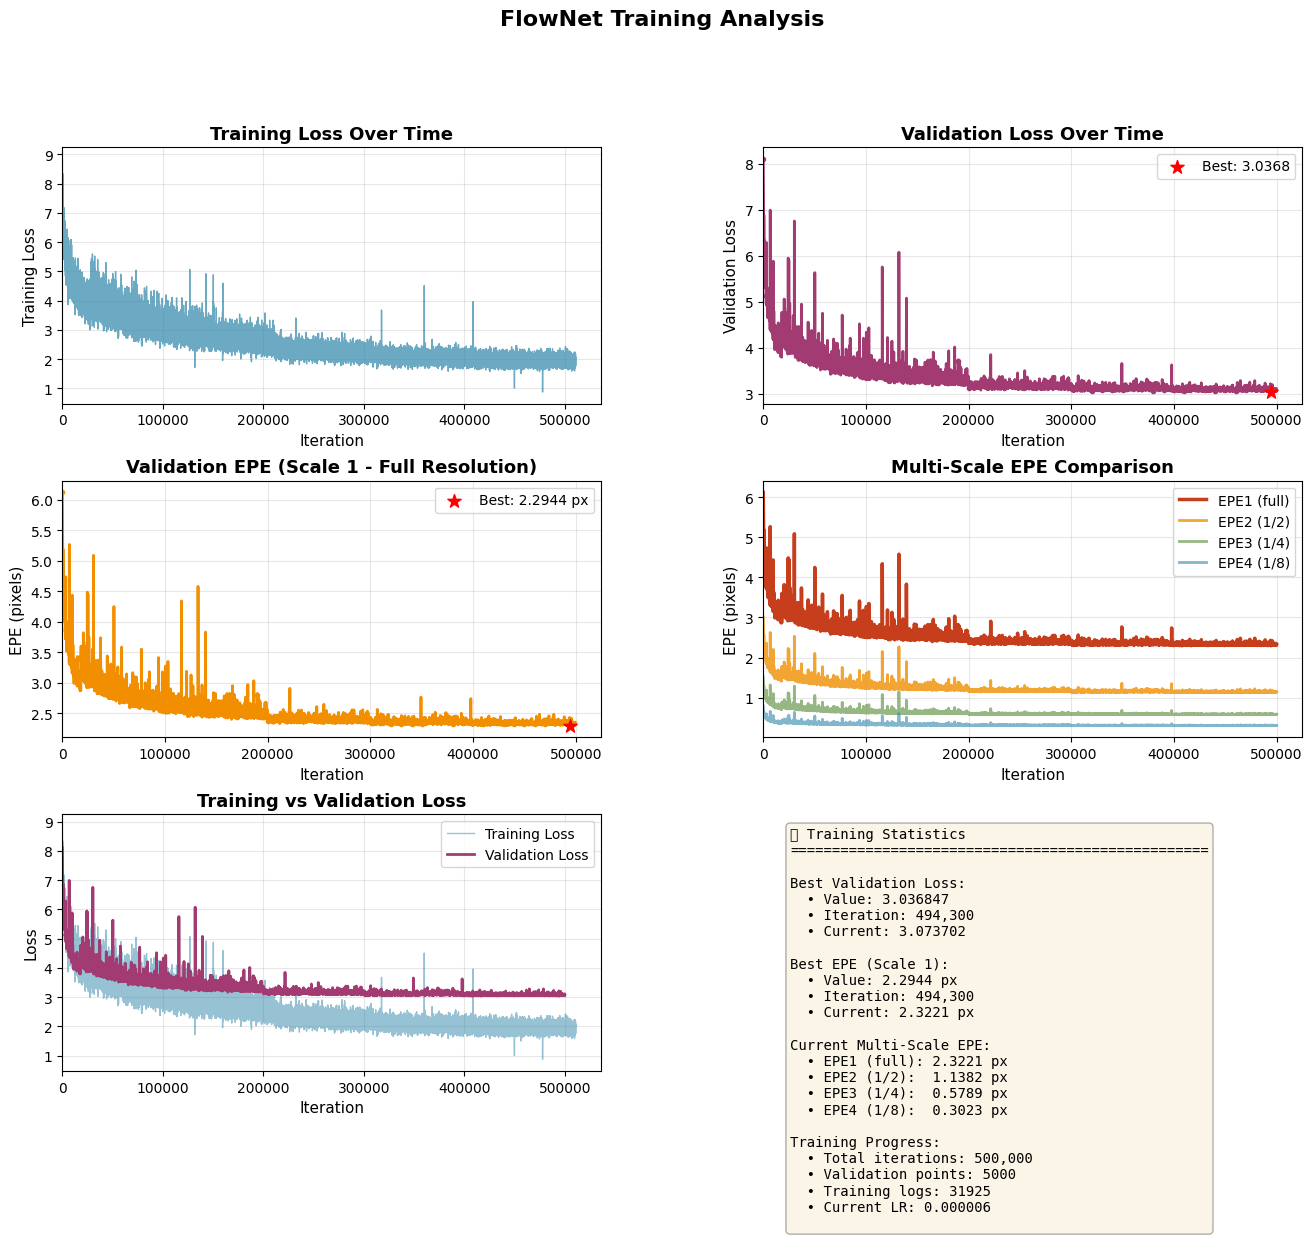


📊 TRAINING DATA SUMMARY
✓ Best validation loss: 3.036847 at iteration 494,300
✓ Best EPE: 2.2944 px at iteration 494,300
✓ Total validation points: 5000
✓ Total training loss logs: 31925
✓ Current iteration: 500,000

✅ Loaded checkpoint: ./checkpoints\checkpoint_iteration_500000.pth (iteration 500000)


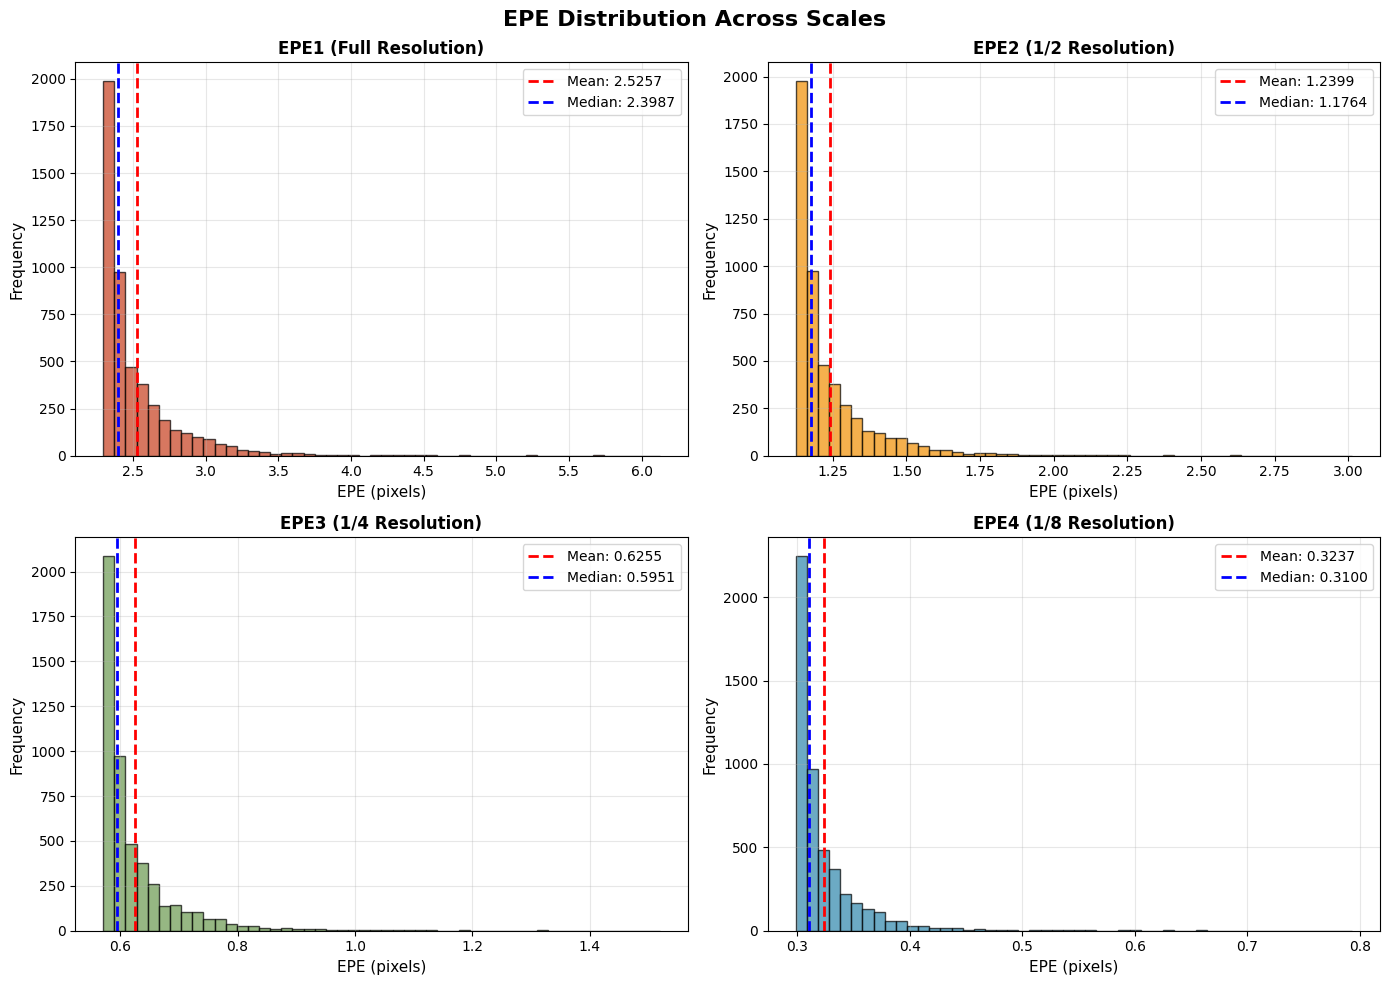

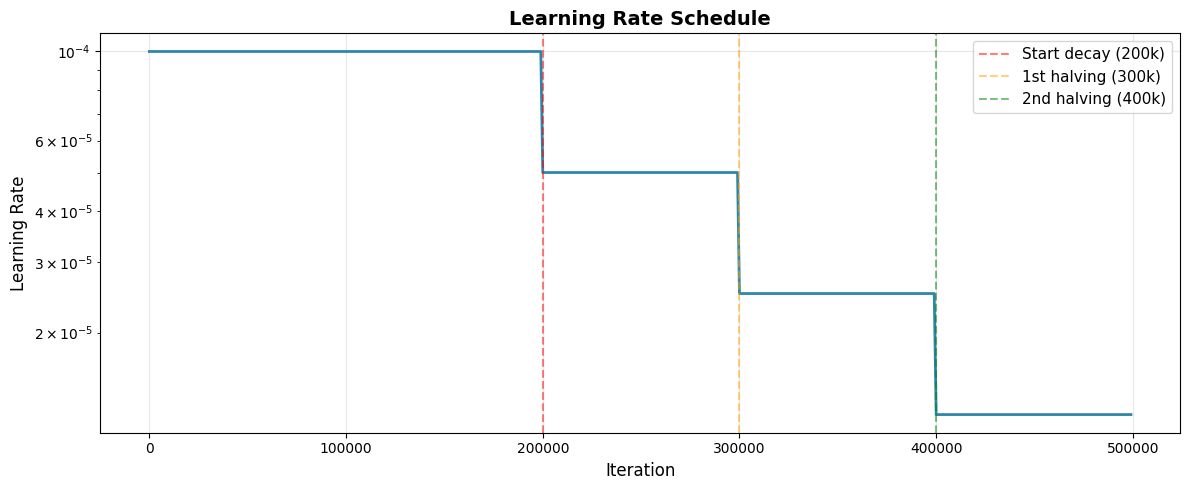

In [5]:
# Cell: Comprehensive Training Data Visualization
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch

def visualize_training_data(checkpoint_path='./checkpoints', figsize=(16, 12)):
    """
    Load checkpoint and create comprehensive visualizations of training data.

    Args:
        checkpoint_path: Path to checkpoint directory
        figsize: Figure size for plots
    """
    # Load checkpoint
    checkpoint = load_checkpoint_generic(checkpoint_path, device='cpu')

    if not checkpoint:
        print("❌ No checkpoint found!")
        return

    # Extract data
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_epes = checkpoint.get('val_epes', [])
    iterations_log = checkpoint.get('iterations_log', [])
    val_epes_multiscale = checkpoint.get('val_epes_multiscale', [])

    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # 1. Training Loss (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    if train_losses:
        train_iters = range(log_interval, len(train_losses) * log_interval + 1, log_interval)
        ax1.plot(train_iters, train_losses, color='#2E86AB', alpha=0.7, linewidth=1)
        ax1.set_xlabel('Iteration', fontsize=11)
        ax1.set_ylabel('Training Loss', fontsize=11)
        ax1.set_title('Training Loss Over Time', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(left=0)

    # 2. Validation Loss (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    if val_losses and iterations_log:
        ax2.plot(iterations_log, val_losses, color='#A23B72', linewidth=2, marker='o',
                markersize=3, markevery=max(1, len(val_losses)//50))
        ax2.set_xlabel('Iteration', fontsize=11)
        ax2.set_ylabel('Validation Loss', fontsize=11)
        ax2.set_title('Validation Loss Over Time', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(left=0)

        # Mark best validation
        best_idx = val_losses.index(min(val_losses))
        ax2.scatter(iterations_log[best_idx], val_losses[best_idx],
                   color='red', s=100, zorder=5, marker='*',
                   label=f'Best: {val_losses[best_idx]:.4f}')
        ax2.legend(fontsize=10)

    # 3. Validation EPE (Scale 1) - middle left
    ax3 = fig.add_subplot(gs[1, 0])
    if val_epes and iterations_log:
        ax3.plot(iterations_log, val_epes, color='#F18F01', linewidth=2, marker='o',
                markersize=3, markevery=max(1, len(val_epes)//50))
        ax3.set_xlabel('Iteration', fontsize=11)
        ax3.set_ylabel('EPE (pixels)', fontsize=11)
        ax3.set_title('Validation EPE (Scale 1 - Full Resolution)', fontsize=13, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.set_xlim(left=0)

        # Mark best EPE
        best_idx = val_epes.index(min(val_epes))
        ax3.scatter(iterations_log[best_idx], val_epes[best_idx],
                   color='red', s=100, zorder=5, marker='*',
                   label=f'Best: {val_epes[best_idx]:.4f} px')
        ax3.legend(fontsize=10)

    # 4. Multi-Scale EPE Comparison - middle right
    ax4 = fig.add_subplot(gs[1, 1])
    if val_epes_multiscale and iterations_log:
        epe1 = [v['epe1'] for v in val_epes_multiscale]
        epe2 = [v['epe2'] for v in val_epes_multiscale]
        epe3 = [v['epe3'] for v in val_epes_multiscale]
        epe4 = [v['epe4'] for v in val_epes_multiscale]

        ax4.plot(iterations_log, epe1, label='EPE1 (full)', linewidth=2.5, color='#C73E1D')
        ax4.plot(iterations_log, epe2, label='EPE2 (1/2)', linewidth=2, color='#F18F01', alpha=0.8)
        ax4.plot(iterations_log, epe3, label='EPE3 (1/4)', linewidth=2, color='#6A994E', alpha=0.7)
        ax4.plot(iterations_log, epe4, label='EPE4 (1/8)', linewidth=2, color='#2E86AB', alpha=0.6)

        ax4.set_xlabel('Iteration', fontsize=11)
        ax4.set_ylabel('EPE (pixels)', fontsize=11)
        ax4.set_title('Multi-Scale EPE Comparison', fontsize=13, fontweight='bold')
        ax4.legend(fontsize=10, loc='upper right')
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim(left=0)

    # 5. Training vs Validation Loss - bottom left
    ax5 = fig.add_subplot(gs[2, 0])
    if train_losses and val_losses and iterations_log:
        train_iters = range(log_interval, len(train_losses) * log_interval + 1, log_interval)
        ax5.plot(train_iters, train_losses, label='Training Loss',
                color='#2E86AB', alpha=0.5, linewidth=1)
        ax5.plot(iterations_log, val_losses, label='Validation Loss',
                color='#A23B72', linewidth=2)
        ax5.set_xlabel('Iteration', fontsize=11)
        ax5.set_ylabel('Loss', fontsize=11)
        ax5.set_title('Training vs Validation Loss', fontsize=13, fontweight='bold')
        ax5.legend(fontsize=10)
        ax5.grid(True, alpha=0.3)
        ax5.set_xlim(left=0)

    # 6. Statistics Summary - bottom right
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')

    # Compute statistics
    stats_text = "📊 Training Statistics\n" + "="*50 + "\n\n"

    if val_losses:
        best_val_idx = val_losses.index(min(val_losses))
        stats_text += f"Best Validation Loss:\n"
        stats_text += f"  • Value: {min(val_losses):.6f}\n"
        stats_text += f"  • Iteration: {iterations_log[best_val_idx]:,}\n"
        stats_text += f"  • Current: {val_losses[-1]:.6f}\n\n"

    if val_epes:
        best_epe_idx = val_epes.index(min(val_epes))
        stats_text += f"Best EPE (Scale 1):\n"
        stats_text += f"  • Value: {min(val_epes):.4f} px\n"
        stats_text += f"  • Iteration: {iterations_log[best_epe_idx]:,}\n"
        stats_text += f"  • Current: {val_epes[-1]:.4f} px\n\n"

    if val_epes_multiscale:
        last_ms = val_epes_multiscale[-1]
        stats_text += f"Current Multi-Scale EPE:\n"
        stats_text += f"  • EPE1 (full): {last_ms['epe1']:.4f} px\n"
        stats_text += f"  • EPE2 (1/2):  {last_ms['epe2']:.4f} px\n"
        stats_text += f"  • EPE3 (1/4):  {last_ms['epe3']:.4f} px\n"
        stats_text += f"  • EPE4 (1/8):  {last_ms['epe4']:.4f} px\n\n"

    stats_text += f"Training Progress:\n"
    stats_text += f"  • Total iterations: {checkpoint.get('iteration', 'N/A'):,}\n"
    stats_text += f"  • Validation points: {len(val_losses)}\n"
    stats_text += f"  • Training logs: {len(train_losses)}\n"
    stats_text += f"  • Current LR: {checkpoint.get('lr', 'N/A'):.6f}\n"

    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.suptitle('FlowNet Training Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.show()

    # Print summary to console
    print("\n" + "="*70)
    print("📊 TRAINING DATA SUMMARY")
    print("="*70)
    if val_losses:
        print(f"✓ Best validation loss: {min(val_losses):.6f} at iteration {iterations_log[val_losses.index(min(val_losses))]:,}")
    if val_epes:
        print(f"✓ Best EPE: {min(val_epes):.4f} px at iteration {iterations_log[val_epes.index(min(val_epes))]:,}")
    print(f"✓ Total validation points: {len(val_losses)}")
    print(f"✓ Total training loss logs: {len(train_losses)}")
    print(f"✓ Current iteration: {checkpoint.get('iteration', 'N/A'):,}")
    print("="*70 + "\n")


def plot_epe_distribution(checkpoint_path='./checkpoints'):
    """Plot distribution of EPE values across all scales"""
    checkpoint = load_checkpoint_generic(checkpoint_path, device='cpu')

    if not checkpoint or 'val_epes_multiscale' not in checkpoint:
        print("❌ No multiscale EPE data found!")
        return

    val_epes_multiscale = checkpoint['val_epes_multiscale']

    epe1 = [v['epe1'] for v in val_epes_multiscale]
    epe2 = [v['epe2'] for v in val_epes_multiscale]
    epe3 = [v['epe3'] for v in val_epes_multiscale]
    epe4 = [v['epe4'] for v in val_epes_multiscale]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('EPE Distribution Across Scales', fontsize=16, fontweight='bold')

    scales = [
        (epe1, 'EPE1 (Full Resolution)', '#C73E1D'),
        (epe2, 'EPE2 (1/2 Resolution)', '#F18F01'),
        (epe3, 'EPE3 (1/4 Resolution)', '#6A994E'),
        (epe4, 'EPE4 (1/8 Resolution)', '#2E86AB')
    ]

    for idx, (epe_data, title, color) in enumerate(scales):
        ax = axes[idx // 2, idx % 2]
        ax.hist(epe_data, bins=50, color=color, alpha=0.7, edgecolor='black')
        ax.axvline(np.mean(epe_data), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {np.mean(epe_data):.4f}')
        ax.axvline(np.median(epe_data), color='blue', linestyle='--', linewidth=2,
                  label=f'Median: {np.median(epe_data):.4f}')
        ax.set_xlabel('EPE (pixels)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_learning_rate_schedule(max_iterations=500000):
    """Visualize the learning rate schedule"""
    iterations = list(range(0, max_iterations, 1000))
    lrs = []

    for it in iterations:
        if it >= 200000:
            num_halvings = (it - 200000) // 100000 + 1
            lr = 1e-4 / (2 ** num_halvings)
        else:
            lr = 1e-4
        lrs.append(lr)

    plt.figure(figsize=(12, 5))
    plt.plot(iterations, lrs, linewidth=2, color='#2E86AB')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    # Mark transition points
    plt.axvline(200000, color='red', linestyle='--', alpha=0.5, label='Start decay (200k)')
    plt.axvline(300000, color='orange', linestyle='--', alpha=0.5, label='1st halving (300k)')
    plt.axvline(400000, color='green', linestyle='--', alpha=0.5, label='2nd halving (400k)')
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


# Execute all visualizations
visualize_training_data('./checkpoints')
plot_epe_distribution('./checkpoints')
plot_learning_rate_schedule(max_iterations=500000)